Reading Standard calibration media extended

In [2]:
# importing everitying
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import physics

In [3]:
# reading the data form the excel file
df = pd.read_excel('../Standard calibration in culture media_extended.xlsx', sheet_name='Raw data', )
df.head()

,E0_Blank_culture media MH - moving average baseline,Unnamed: 1,Pyo 100 uM_MH - moving average baseline,Unnamed: 3,Unnamed: 4,Pyo 50 uM_MH - moving average baseline,Unnamed: 6,Unnamed: 7,Pyo 25 uM_MH - moving average baseline,Unnamed: 9,...,Unnamed: 32,Unnamed: 33,Pyo 0.25 uM_MH - moving average baseline,Unnamed: 35,Unnamed: 36,Pyo 0.1 uM_MH - moving average baseline,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,V,µA,µA,µA,µA,µA,µA,µA,µA,µA,...,µA,µA,µA,µA,µA,µA,µA,µA,µA,µA
1,-0.600097,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.595262,0.063593,0.098656,0.109374,0.115718,0.082966,0.110628,0.104234,0.088812,0.082304,...,0.079479,0.075286,0.075833,0.076125,0.079187,0.083927,0.078385,0.110979,0.051843,0.066755
3,-0.590427,0.054031,0.121318,0.130725,0.148006,0.099352,0.122679,0.113728,0.090737,0.073225,...,0.04127,0.070401,0.071166,0.054775,0.054862,0.065697,0.060739,0.079771,0.044581,0.064057
4,-0.585592,0.033967,0.136981,0.152074,0.173293,0.115738,0.113729,0.119721,0.085662,0.085147,...,0.038062,0.048015,0.045499,0.040424,0.044536,0.043967,0.064092,0.062562,0.030319,0.047358


### Dataset structure
- There are 42 signals, stored as column vectors
- The first signal, from the first column, represents the potential - denoted with $E$ and measured in $V$ (volts) - and this potential was applied in all experiments, ensuring the same potential window.
- The other signals represent the cureents - denoted with $I$ and measured in $\mu A$ (microampers) - characteristic to the initial potential $E$ and to the concentration values - denoted with $c$ and measured in $\mu M$ (micromolars), for which the experiment was performed.
- For each concentration were performed a number of readings, as shown bellow:

| $c$ [$\mu M$]| Number of readings |
| -------- | ------- |
| 0 | 1 (the blank signal)|
| 100 | 3 |
| 50 | 3 |
| 25 | 3 |
| 15 | 3 |
| 10 | 3 |
| 7.5 | 3 |
| 5 | 3 |
| 2.5 | 2 |
| 1 | 3 |
| 0.5 | 6 |
| 0.5 | 6 |
| 0.25 | 3 |
| 0.1 | 5 |

### The Problem we are trying to solve
- Create a ML model that predicts the concentration value (in $\mu M$) of a given voltammogram signal.
- The current signal, represented in the voltammogram, can be seen as a function of potential. Therefore, the entire problem can be written as:
$$c = I(E)$$

In [4]:
# extracting potential and current values
concentrations = [
    0,
    100,
    100,
    100,
    50,
    50,
    50,
    25,
    25,
    25,
    15,
    15,
    15,
    10,
    10,
    10,
    7.5,
    7.5,
    7.5,
    5,
    5,
    5,
    2.5,
    2.5,
    1,
    1,
    1,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
    0.25,
    0.25,
    0.25,
    0.1,
    0.1,
    0.1,
    0.1,
    0.1
]
# the same potential was applied to each experiment
potential: np.ndarray = df.iloc[1:, 0].values

# the next columns represent the currents for each experiment
# they will be stored inside a list
currents: list[np.ndarray] = []
for col in df.columns[1:]:
    currents.append(df[col].values[1:])


plotting each voltammogram

In [4]:
# This is not necessary to run every time, only when you want to save the plots

# path = 'voltammograms'
# if not os.path.exists(path):
#     os.makedirs(path)

# for i, current in enumerate(currents):
#     peak = max(current[18:70])
#     peak_voltage = potential[list(current).index(peak)]
# # create a new figure for each plot and close it after saving
#     plt.figure(figsize=(6, 4))
#     plt.plot(potential, current)
#     plt.plot(peak_voltage, peak, 'rx')
#     plt.grid()
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (µA)')
#     plt.title(f'Voltammogram {i},\nConcentration: {concentrations[i]} µM,\npeak at {round(peak, 2)} µA and {round(peak_voltage, 2)} V')
#     fname = f'voltammograms/voltammogram_{i:02d}.jpg'
#     plt.savefig(fname, bbox_inches='tight', dpi=200)
#     # plt.show()
#     plt.close()


# Pre-processing the signals

### Extracting the base noise from eachh signal
The second column, represents the currents registered when no drop of pyocyanin was present. This signal needs to be substracted form the rest of the currents to standarsize all the signals.

In [5]:
base_signal = currents[0]
normalized_currents: list[np.ndarray] = []

for current in currents:
    normalized_current = current - base_signal
    normalized_currents.append(normalized_current)

# for i, normalized_current in enumerate(normalized_currents):
#     peak = max(normalized_current[18:70])
#     peak_voltage = potential[list(normalized_current).index(peak)]
#     plt.figure(figsize=(6, 4))
#     plt.plot(potential, normalized_current)
#     plt.plot(peak_voltage, peak, 'rx')
#     plt.grid()
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Normalized Current (µA)')
#     plt.title(f'Normalized Voltammogram {i},\nConcentration: {concentrations[i]} µM,\npeak at {round(peak, 2)} µA and {round(peak_voltage, 2)} V')
#     fname = f'voltammograms/normalized_voltammogram_{i:02d}.jpg'
#     plt.savefig(fname, bbox_inches='tight', dpi=200)
#     # plt.show()
#     plt.close()

### Signal smoothing
The signal will be smoothed using the Savitzky-Golay algorithm. This step is useful when processing low concentrations due to noise perturbations.

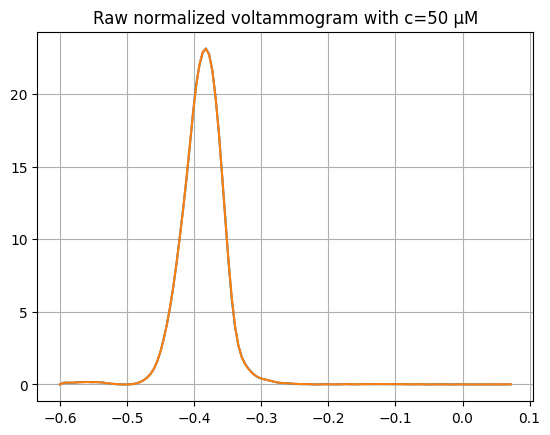

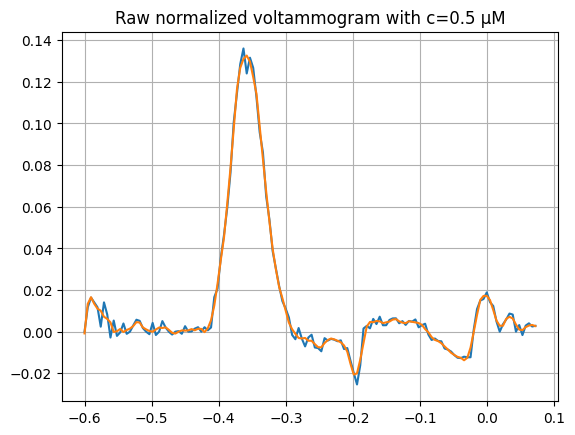

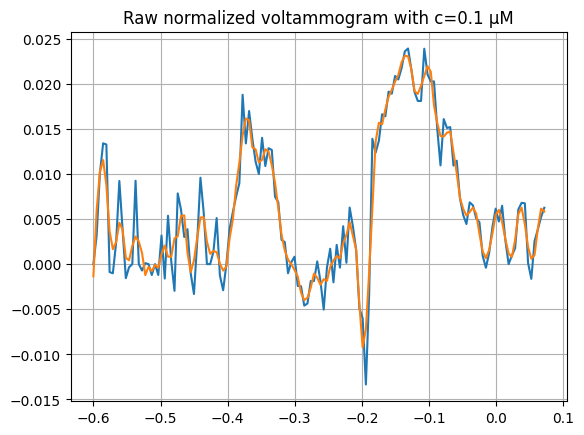

In [6]:
from scipy.signal import savgol_filter

window_length = 7
polyorder = 3

# taking 3 test signals from different concentrations
# c = 50 µM
test_current = currents[5][:140]
smoothed_current = savgol_filter(test_current, window_length=window_length, polyorder=polyorder)
plt.plot(potential[:140], test_current)
plt.plot(potential[:140], smoothed_current[:140])
plt.title(f'Raw normalized voltammogram with c={concentrations[5]} µM')
plt.grid()
plt.show()

# c = 0.5 µM
test_current = normalized_currents[32][:140]
smoothed_current = savgol_filter(test_current, window_length=window_length, polyorder=polyorder)
plt.plot(potential[:140], test_current)
plt.plot(potential[:140], smoothed_current[:140])
plt.title(f'Raw normalized voltammogram with c={concentrations[32]} µM')
plt.grid()
plt.show()

# c = 0.1 µM
test_current = normalized_currents[40][:140]
smoothed_current = savgol_filter(test_current, window_length=window_length, polyorder=polyorder)
plt.plot(potential[:140], test_current)
plt.plot(potential[:140], smoothed_current[:140])
plt.title(f'Raw normalized voltammogram with c={concentrations[40]} µM')
plt.grid()
plt.show()


In [7]:
# smothing all the signals

window_length = 7
polyorder = 3

smoothed_currents: list[np.ndarray] = []
for current in normalized_currents:
    smoothed_current = savgol_filter(current, window_length=window_length, polyorder=polyorder)
    smoothed_currents.append(smoothed_current)

# cleaning up memory
del normalized_currents
del currents

currents = smoothed_currents

# Feature extraction
---
### Category A: Electrochemical Peak Features
- the highest importance

| * | Subcategory   | Feature                   | Details              |
| --- | ------------- | ------------------------- | -------------------- |
| 1. | Peak location | Peak potential ($E_p$)      | Redox potential - the maximum current value |
| 2. | Peak height   | Peak current ($I_p$)        | Concentration proxy  |
| 3. | Peak width    | FWHM                      | Kinetics + diffusion |
| 4. | Peak area     | $\int I dE$                     | Total charge         |
| 5. | Shape         | Left slope | Symmetry             |
| 6. | Shape         | Right slope | Symmetry             |
| 7. | Sharpness     | Second derivative at peak | Reversibility        |
| 8. | Peak ratio    | I_peak / baseline RMS     | SNR                  |



Peak current for concentration 50 µM: 23.101233847561723 µA
Peak potential for concentration 50 µM: -0.382515 V
FWHM for concentration 50 µM: 0.062857 V
Peak area (AUC) for concentration 50 µM: 1.5999427864242244 µA·V
Right slope coefficients: [-479.69605435 -158.1906574 ]


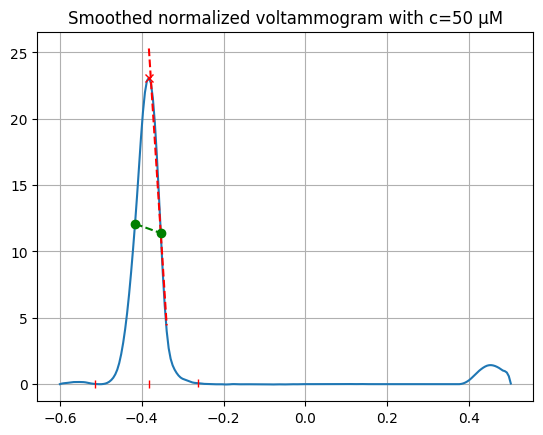

In [ ]:
test_current = currents[5]

peak_current, peak_potential, _ = physics.get_peak_values(potential, test_current)

fwhm = physics.get_peak_FWHM(potential, test_current, threshold_ratio=0.5)
auc = physics.get_peak_area(potential, test_current)


print(f'Peak current for concentration {concentrations[5]} µM: {peak_current} µA')
print(f'Peak potential for concentration {concentrations[5]} µM: {peak_potential} V')
print(f'FWHM for concentration {concentrations[5]} µM: {fwhm} V')
print(f'Peak area (AUC) for concentration {concentrations[5]} µM: {auc} µA·V') 
threshold = peak_current * 0.5
indices_above_threshold = np.where(test_current >= threshold)[0]
left_idx = indices_above_threshold[0]
right_idx = indices_above_threshold[-1] + 1

plt.plot(
    potential, test_current,
    peak_potential, peak_current, 'rx',
    peak_potential, 0, 'r|',
    potential[left_idx], test_current[left_idx], 'go',
    potential[right_idx], test_current[right_idx], 'go',
    [potential[left_idx], potential[right_idx]], [test_current[left_idx], test_current[right_idx]], 'g--',
    potential[18], test_current[18], 'r|',
    potential[70], test_current[70], 'r|',
)
plt.title(f'Smoothed normalized voltammogram with c={concentrations[5]} µM')
plt.grid()
plt.show()

In [9]:
physics.get_left_slope(potential, test_current)

ValueError: data type <class 'numpy.object_'> not inexact

### Category B: Baseline & Background

In [ ]:
from scipy.stats import linregress
import numpy as np

def get_features_category_b(potential, current):
    # index of max current (peak) 
    # we go relative to this point 
    peak_idx = np.argmax(current)

    # defining the three zones based on the peak: baseline, pre-preak and post-peak
    # we consider the first 15 points as baseline 
    baseline_end = 15
    base_slice = slice(0, baseline_end) 

    #extract data
    x_base = potential[base_slice]
    y_base = current[base_slice]

    # 1. Mean Baseline Current: avg of the flat part (before the reaction)
    mean_base = np.mean(y_base)

    # 2. Baseline slope: slope of the baseline (to see if there is a drift / tilt)
    # using linregress
    if len(x_base) > 1:
        slope, intercept, _, _, _ = linregress(x_base, y_base)
        
        # calc residuals (actual - predicted) to find noise
        y_pred = slope * x_base + intercept
        residuals = y_base - y_pred
        # 5. Baseline RMS noise: identify differences between actual point and the linear regression line
        rms_noise = np.sqrt(np.mean(residuals**2))
    else:
        slope = 0
        rms_noise = 0

    # 3. Pre-peak slope: calc how steep the climb is
    pre_start = max(0, peak_idx - 5)
    if peak_idx > pre_start:
        pre_slope, _, _, _, _ = linregress(potential[pre_start:peak_idx], 
                                           current[pre_start:peak_idx])
    else:
        pre_slope = 0

    # 4. post-peak slope: calc how steep the decline is
    post_end = min(len(current), peak_idx + 5)
    if post_end > peak_idx:
        post_slope, _, _, _, _ = linregress(potential[peak_idx:post_end], 
                                            current[peak_idx:post_end])
    else:
        post_slope = 0
    return {
        "Mean_Baseline": mean_base,
        "Baseline_Slope": slope,
        "Baseline_RMS": rms_noise,
        "Pre_Peak_Slope": pre_slope,
        "Post_Peak_Slope": post_slope
    }

In [ ]:
features_list = []
for i, current in enumerate(currents):
    # fix data if necessary
    current = np.array(current, dtype=float)
    potential = np.array(potential, dtype=float)

    # get features
    features = get_features_category_b(potential, current)
    features['Signal_idx'] = i
    features_list.append(features)

df_task_b = pd.DataFrame(features_list)
print(df_task_b.head())
df_task_b.to_excel('features_category_b.xlsx', index=False, sheet_name='category_b_features')

   Mean_Baseline  Baseline_Slope  Baseline_RMS  Pre_Peak_Slope  \
0       0.000000        0.000000      0.000000        0.000000   
1       0.158199        2.382965      0.054111      247.834224   
2       0.154020        1.788466      0.058699      303.456176   
3       0.137684        1.205310      0.050034      293.628599   
4       0.101979        1.504276      0.033273      340.048838   

   Post_Peak_Slope  Signal_idx  
0         0.000000           0  
1      -328.194669           1  
2      -208.543062           2  
3      -257.609707           3  
4      -305.288635           4  


### Category C: Shape & Geometry

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis


def get_features_category_c(potential, current):
    # identify peak (relative to this point)
    peak_idx = np.argmax(current)
    peak_height = current[peak_idx]

    # peak region for statistic stats (skewness, kurtosis)
    # only points above 10% of peak height (avoid noise)
    threshold = peak_height * 0.10
    peak_region_mask = current > threshold
    y_peak_region = current[peak_region_mask]

    # 1. Skewness: measure of asymmetry (leaning left or right)
    if len(y_peak_region) > 3:
        feat_skew = skew(y_peak_region)
    else:
        feat_skew = 0

    # 2. Kurtosis: measure of sharpness (pointy or flat)
    if len(y_peak_region) > 3:
        feat_kurt = kurtosis(y_peak_region)
    else:
        feat_kurt = 0

    # thresholds for rise/fall time calculations (10% and 90%)
    low_thresh = 0.10 * peak_height
    high_thresh = 0.90 * peak_height

    # 3. Rise Time: calc time (potential) to go from 10% to 90% up the peak
    # slice array up to the peak
    rise_side_current = current[:peak_idx]
    rise_side_potential = potential[:peak_idx]

    if len(rise_side_current) > 0:
        # find indices closest to 10% and 90%
        idx_10 = (np.abs(rise_side_current - low_thresh)).argmin()
        idx_90 = (np.abs(rise_side_current - high_thresh)).argmin()
        
        # calc potential difference
        rise_time = abs(rise_side_potential[idx_90] - rise_side_potential[idx_10])
    else:
        rise_time = 0

    # 4. Fall Time: calc time (potential) to drop from 90% to 10% down the peak
    # slice array after the peak
    fall_side_current = current[peak_idx:]
    fall_side_potential = potential[peak_idx:]

    if len(fall_side_current) > 0:
        idx_90_fall = (np.abs(fall_side_current - high_thresh)).argmin()
        idx_10_fall = (np.abs(fall_side_current - low_thresh)).argmin()
        
        fall_time = abs(fall_side_potential[idx_10_fall] - fall_side_potential[idx_90_fall])
    else:
        fall_time = 0

    # 5. Inflection Points: points where curvature changes (convex/concave)
    # calc 1st and 2nd derivatives
    d1 = np.gradient(current)
    d2 = np.gradient(d1)
    
    # count how many times 2nd derivative changes sign
    sign_changes = np.diff(np.sign(d2))
    # we filter for changes inside our defined peak region
    inflections = np.sum(np.abs(sign_changes[peak_region_mask[:-1]]) > 0)

    return {
        "Skewness": feat_skew,
        "Kurtosis": feat_kurt,
        "Rise_Time": rise_time,
        "Fall_Time": fall_time,
        "Inflection_Points": inflections
    }

In [ ]:
# process for category C
task_c_results = []
for i, current in enumerate(currents):
    # fix data if necessary
    current = np.array(current, dtype=float)
    potential = np.array(potential, dtype=float)

    feats = get_features_category_c(potential, current)
    feats['Signal_Index'] = i
    task_c_results.append(feats)

df_task_c = pd.DataFrame(task_c_results)
print(df_task_c.head())
df_task_c.to_excel('features_category_c.xlsx', index=False, sheet_name='category_c_features')

   Skewness  Kurtosis  Rise_Time  Fall_Time  Inflection_Points  Signal_Index
0  0.000000  0.000000   0.000000   0.000000                  0             0
1 -0.141511 -1.471030   0.058022   0.038681                  2             1
2 -0.191636 -1.450444   0.062857   0.038681                  2             2
3 -0.185164 -1.454574   0.058022   0.043516                  2             3
4  0.029624 -1.448719   0.053187   0.043516                  2             4


### Category D: : Statistical Descriptors

In [ ]:
from scipy.stats import entropy
import numpy as np
import pandas as pd

def get_features_category_d(potential, current):
    # potential kept for consistency, not used in calculations
    # A. Full Signal
    region_full = current
    
    # B. Baseline Window
    # consistent with category B, first 15 points
    baseline_end = 15
    region_base = current[:baseline_end]
    
    # C. Peak Window
    # consistent with category C, points > 10% of peak height
    peak_val = np.max(current)
    threshold = 0.10 * peak_val
    region_peak = current[current > threshold]
    
    # Helper function to calculate stats for any given region data
    def calculate_stats(data, region_name):
        if len(data) == 0:
            return {}
            
        # 1. Basic Stats: mean, std, variance
        val_mean = np.mean(data)
        val_std = np.std(data)
        val_var = np.var(data)
        
        # 2. Max / Min ratio
        # we add a small epsilon (1e-9) to avoid dividing by zero if min is 0
        val_min = np.min(data)
        val_max = np.max(data)
        val_max_min_ratio = val_max / (val_min + 1e-9)
        
        # 3. Percentiles (25%, 50%, 75%)
        # 50% is the median
        p25 = np.percentile(data, 25)
        p50 = np.percentile(data, 50)
        p75 = np.percentile(data, 75)
        
        # 4. Entropy
        # measures the "randomness" of data distribution
        # we normalize data to sum to 1 to treat it like a probability distribution
        # using abs() to handle if there is negative noise
        data_norm = np.abs(data) / (np.sum(np.abs(data)) + 1e-9)
        val_entropy = entropy(data_norm)
        
        return {
            f"{region_name}_mean": val_mean,
            f"{region_name}_std": val_std,
            f"{region_name}_var": val_var,
            f"{region_name}_max_min": val_max_min_ratio,
            f"{region_name}_p25": p25,
            f"{region_name}_p50": p50,
            f"{region_name}_p75": p75,
            f"{region_name}_entropy": val_entropy
        }

    features = {}
    
    # merge dictionaries from all 3 regions
    features.update(calculate_stats(region_full, "Full"))
    features.update(calculate_stats(region_peak, "Peak"))
    features.update(calculate_stats(region_base, "Base"))
    
    return features

In [ ]:
task_d_results = []
for i, current in enumerate(currents):
    # fix data if necessary
    current = np.array(current, dtype=float)
    potential = np.array(potential, dtype=float)

    feats = get_features_category_d(potential, current)
    feats['Signal_Index'] = i
    task_d_results.append(feats)

df_task_d = pd.DataFrame(task_d_results)
print(df_task_d.head())
df_task_d.to_excel('features_category_d.xlsx', index=False, sheet_name='category_d_features')

   Full_mean  Full_std   Full_var  Full_max_min  Full_p25  Full_p50  Full_p75  \
0   0.000000  0.000000   0.000000      0.000000  0.000000  0.000000  0.000000   
1   2.646624  7.659757  58.671876  -1137.557262 -0.001981  0.003850  0.340234   
2   2.648366  7.591250  57.627074  -1131.973527 -0.001705  0.003821  0.339988   
3   2.579393  7.447072  55.458879  -1119.537336 -0.000912  0.006966  0.328276   
4   1.444520  4.392103  19.290567   -793.643579 -0.000623  0.004974  0.250891   

   Full_entropy  Base_mean  Base_std  ...  Base_entropy  Signal_Index  \
0           NaN   0.000000  0.000000  ...           NaN             0   
1      3.434823   0.158199  0.073527  ...      2.559438             1   
2      3.444802   0.154020  0.069580  ...      2.571732             2   
3      3.441214   0.137684  0.056012  ...      2.598399             3   
4      3.414704   0.101979  0.045767  ...      2.568923             4   

   Peak_mean   Peak_std    Peak_var  Peak_max_min   Peak_p25   Peak_p50  \